<a href="https://colab.research.google.com/github/pedrotorres08/CNPQuniversal/blob/main/reliable_prossumer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1- Introduction**<br>
**1.1 - Definitions**<br>
*Reliable prossumer* (RP): a low-voltage prossumer connected to the microgrid (POC MG) that has both distributed generation and distributed storage, and is able to operate off-grid for a certain period. In this project, it is assumed that the distributed generation is PV, and storage is a BESS
<br>

*   $P_{MG}$ - microgrid input power
*   $P_{BESS}$ - BESS power (optimizable)
*   $P_{IN}$ - Power of inflexible, non-critical loads
*   $P_{FN}$ - Power of flexible, non-critical loads (optimizable)
*   $P_{IC}$ - Power of inflexible, critical loads
*   $P_{FC}$ - Power of flexible, critical loads (optimizable)
*   $P_{DPV}$ - Distributed PV power
<br><br>
Here we define a flexible load those that have a certain degree of flexibility in its operation scheduling on a day-ahead basis (opposing to inflexible ones) and critical loads are those that for a given day-ahead schedule MUST operate irrespective of external source availability (i.e. MG), while non-critical loads are not constrained in this regard. Load classification varies from user-specific needs, but some examples can be given:<br>
*   Inflexible, non-critical: lighting 
*   Flexible, non-critical: entertaining (TV, etc)
*   Inflexible, critical: PC + internet for home office
*   Flexible, critical: electric shower
<br><br>

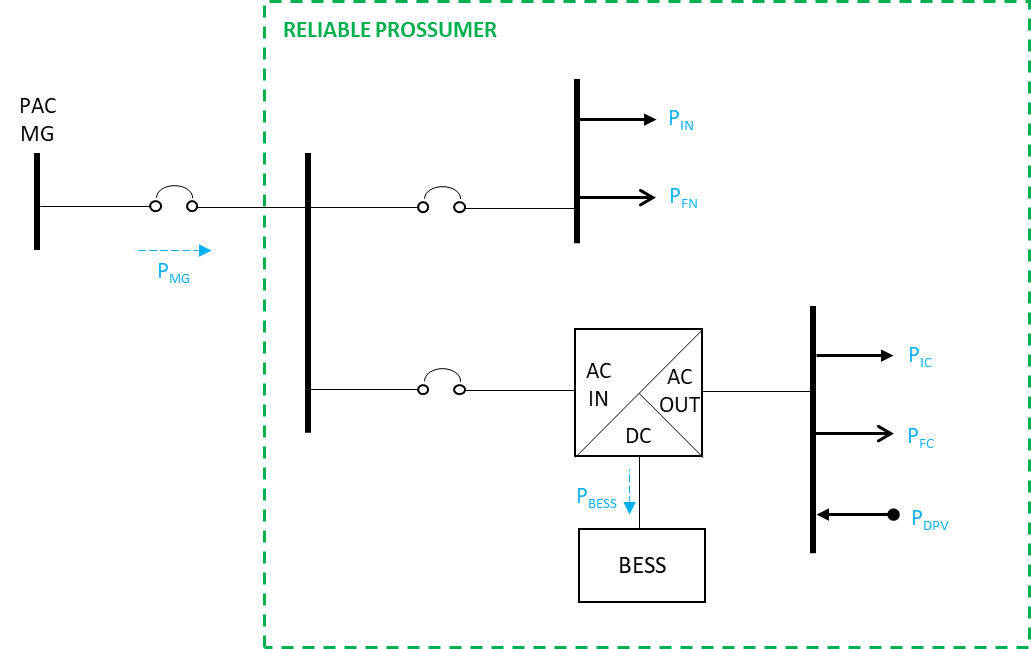
Power balance equation (time index omitted):<br>
$P_{MG}  = P_{BESS} + P_{FC} +  P_{IC} +  P_{FN} +  P_{IN} - P_{DPV}$<br>

**1.2 - Cost Function**<br>
The prossumer energy contract with the microgrid supplier is based on a day-ahead TOU tariff scheme, and also accounts the reliability of supply:
<br>
$C_{ES,t} = r_{t}*k_{t}*P_{MG,t} - p_{t}*r_{t}$<br>
Where:<br>
*   $C_{ES,t}$ - cost of energy supply, at a given time t<br>
*   $r_{t}$ - probability of guaranteed service at a given time t<br>
*   $p_{t}$ - penalty factor due unavailability of supply<br>
*   $k_{t}$ - energy supply tariff, at a given time t, in $/kWh<br>

$r_{t}$ is the probability of guaranteed service by the energy supply provider (ESP), on a TOU day-ahead basis, where $r_{t} = 1$ indicates that the ESP is 100 % confident that service will be available at a given time t in the next day. When a severe storm is forecasted, for instance, the ESP might reduce its confidence in service, thus adjusting $r_{t}$.<br>
$p_{t}$ is the penalty factor that accounts for interruptions in energy supply. This can be understood as a discount applied to the overall energy supply cost whenever service is interrupted. As $p_{t}$ is multiplied by $r_{t}$ the ESP is incentivized to determine accurate values for $r_{t}$ which in turn is an important input for the prossumer local energy scheduling.

**1.3 - Energy Management Controller**<br>
The RP energy management controller (EMC) schedules/dispatches the following variables: $P_{BESS}$, $P_{FC}$, $P_{FN}$. While $P_{DPV}$, $P_{IC}$, $P_{IN}$ are inputs that must be internally forecasted by the RP EMC. $r_{t}$, $p_{t}$ and $k_{t}$ are inputs external to the RP.

## **2 - Optimization model**
**2.1 - Cost Function**<br>
$min(\sum_{t=1}^{nt} C_{ES,t})$<br>where $nt$ is the number of timeslots for daily simulation (e.g. $nt = 24$ for an hourly timestep)<br><br>

**2.2 - Inputs**<br>
$r_{t}$, $p_{t}$, $k_{t}$, $P_{DPV,t}$, $\sum_{i=1}^{N_{IC}}P_{IC,i,t}$, $\sum_{i=1}^{N_{IN}}P_{IN,i,t}$<br>
where $N_{IN}$ is the number of inflexible, non-critical loads, and $N_{IC}$ is the number of inflexible, critical loads. <br><br>

**2.3 - Optimizing Variables**<br>
$P_{BESS,t}$, $\sum_{i=1}^{N_{FC}}P_{FC,i,t}$, $\sum_{i=1}^{N_{FN}}P_{FN,i,t}$<br>
where $N_{FN}$ is the number of flexible, non-critical loads, and $N_{FC}$ is the number of flexible, critical loads. <br><br>

**2.4 - Constraints**<br>


## **3 - Implementation**

In [17]:
#Conexao ao google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
#Instalar PVlib
!pip install -q pvlib

#Importar bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from pvlib import pvsystem, modelchain

In [45]:
#Definicoes iniciais
nt = 96 #Numero de timeslots

In [20]:
#Ler Curva de Carga
filenameCCbt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_BT.parquet'
filenameCCmt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_MT.parquet'
CCbt = pd.read_parquet(filenameCCbt)
CCmt = pd.read_parquet(filenameCCmt)

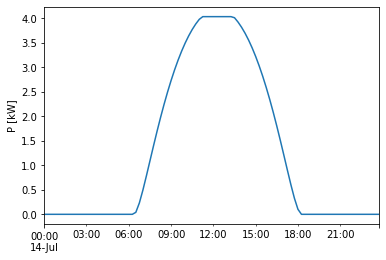

In [43]:
#Forecast FV (clear sky)
x_coord = -48
y_coord = 2
z_coord = 0
t0 = '2022-07-14 00:00'
tf = '2022-07-14 23:45'
freqfv = '15min'
gmt_fv = 'Brazil/East'

#Distributed PV generation
tilt_angle = 10
azimuth = 0
Pfv = 5.0 #Potencia em kWp
Pinv = 4.2 #Potencia em kW

loc = Location(y_coord, x_coord, gmt_fv, z_coord)
times = pd.date_range(start=t0, end=tf, freq=freqfv, tz=loc.tz)
cs = loc.get_clearsky(times)

array_kwargs = dict(module_parameters=dict(pdc0=Pfv, gamma_pdc=-0.004),temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3))
arrays = [pvsystem.Array(pvsystem.FixedMount(tilt_angle, azimuth), name='Gerador FV',**array_kwargs)]
system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=Pinv))
mc = modelchain.ModelChain(system, loc, aoi_model='physical',spectral_model='no_loss')
mc.run_model(cs)

mc.results.ac.plot(label='Pfv_CA')
plt.ylabel('P [kW]')
plt.show()

#Pdpv
Pdpv = mc.results.ac

In [46]:
#Inputs de custo
r = 1.0*np.ones(nt) #probability of guaranteed service
p = 2.5*np.ones(nt) #penalty factor due unavailability of supply
k = 0.5*np.ones(nt) #energy supply tariff $/kWh